In [24]:
import os
import glob
import datetime
import statistics
import numpy as np
import pandas as pd
import import_ipynb
from marcap import marcap_data
import FinanceDataReader as fdr
import matplotlib.pyplot as plt

In [25]:
import models.qp as model
#from ncav import get_stocks # NCAV
#from super_value import get_stocks
#from super_quality import get_stocks

In [26]:
MODEL_NAME = 'qp'
DATA_DIR = 'data/daily/8-1'

In [27]:
df_account = pd.DataFrame(columns=['start_date', 'end_date', 'filepath'])
filepaths = glob.glob(DATA_DIR + "/*.csv")
filepaths = sorted(filepaths)

days = []
for i in range(len(filepaths)):
    if i < len(filepaths) - 1: # exclude last item
        start_date =  os.path.basename(filepaths[i])[:-4]
        end_date =  os.path.basename(filepaths[i + 1])[:-4]
        
        day = {'start_date':start_date, 'end_date':end_date, 'filepath':filepaths[i]}
        days.append(day)

df_account = df_account.append(days)

In [28]:
df_account

,start_date,end_date,filepath
0,2002-08-01,2003-08-01,data/daily/8-1/2002-08-01.csv


In [29]:
# 연도별 종목을 구한다.
df_account['stocks'] = df_account.apply(lambda x: model.get_stocks(x.filepath, x.start_date, False), axis=1)

2002-08-01 선정 기업 수 30


In [30]:
# 연도별 수익률을 구한다.
df_account['yield'] = 0.0
df_account['yields'] = 0.0
df_account['yields'] = df_account['yields'].astype('object')
df_account['delisted'] = 0
df_account['delisted_stocks'] = df_account['yields'].astype('object')

for i in range(len(filepaths)):
    if i < len(filepaths) - 1: # exclude last item
        start_date = df_account.iloc[i].start_date
        end_date = df_account.iloc[i].end_date
        
        df_this_year = pd.read_csv(filepaths[i], dtype={"기업코드":"string", "종목코드":"string"})[['종목코드', '주가']]
        df_next_year = pd.read_csv(filepaths[i + 1], dtype={"기업코드":"string", "종목코드":"string"})[['종목코드', '주가']]
        
        stocks = df_account.iloc[i].stocks   
        yields = []
        
        # 종목별 수익률, 상장폐지 기업 수를 구한다.
        delisted = 0 # 상장폐지 기업 수
        delisted_stocks  = []
        for stock in stocks:
            start_price = df_this_year[df_this_year['종목코드'] == stock]['주가'].iloc[0]
            end_price = df_next_year[df_next_year['종목코드'] == stock]['주가']
            
            if len(end_price) == 0:
                end_price = 0
            else:                    
                end_price = end_price.fillna(0) 
                end_price = end_price.iloc[0]
                
            if end_price == 0: # 가격 정보가 없을 경우 상폐
                delisted += 1
                delisted_stocks.append(stock)
            
            # get yield
            yields.append(end_price / start_price)

        # stock 수익률들의 avg가 total 수익률이 된다. (동일 비중이기 때문에)
        mean_yields = statistics.mean(yields)
        df_account.at[i, 'yield'] = mean_yields
        df_account.at[i, 'yields'] = yields
        df_account.at[i, 'delisted'] = delisted
        df_account.at[i, 'delisted_stocks'] = delisted_stocks
        
        print(start_date, '~', end_date, ":", mean_yields)
        
        #break

2002-08-01 ~ 2003-08-01 : 0.8535899132381205


In [12]:
df_account['total'] = df_account['yield'].cumprod()

In [13]:
df_account['cagr'] = 0.0
for i, row in enumerate(df_account.iterrows()):
    df_account.at[i, 'cagr'] = pow(row[1]['total'], 1/(i+1))

In [14]:
def get_win_rate(yield_rates):
    return sum([yield_rate > 1.0 for yield_rate in yield_rates]) / len(yield_rates)

df_account['win_rate'] = df_account.apply(lambda x: get_win_rate(x['yields']), axis=1)

In [15]:
df_account['best_corp'] = df_account.apply(lambda x: max(x['yields']), axis=1)
df_account['worst_corp'] = df_account.apply(lambda x: min(x['yields']), axis=1)

In [16]:
df_account['best_stock_code'] = df_account.apply(lambda x: x['stocks'][np.argmax(x['yields'])], axis=1)
df_account['worst_stock_code'] = df_account.apply(lambda x: x['stocks'][np.argmin(x['yields'])], axis=1)

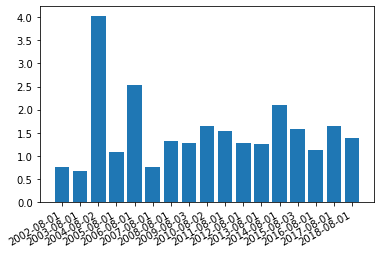

In [17]:
fig, ax = plt.subplots()
plt.bar(df_account['start_date'], df_account['yield'])
fig.autofmt_xdate()
plt.show()

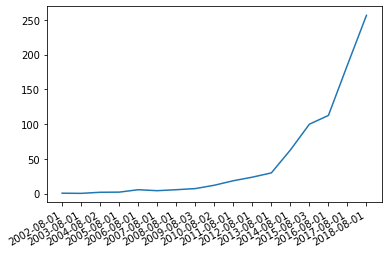

In [18]:
fig, ax = plt.subplots()
ax.plot_date(df_account['start_date'], df_account['total'], marker='', linestyle='-')
fig.autofmt_xdate()
plt.show()

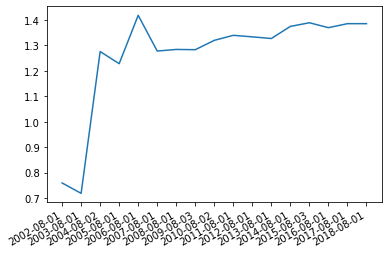

In [19]:
fig, ax = plt.subplots()
ax.plot_date(df_account['start_date'], df_account['cagr'], marker='', linestyle='-')
fig.autofmt_xdate()
plt.show()

In [20]:
1 - min(df_account['yield'])

0.3204363926453925

In [21]:
max(df_account['yield'])

4.0286799618191695

In [22]:
# 가격 정보가 없는 경우 상폐로 처리했음. 실제로 상폐까지는 아니고 거래정지인 경우가 있음
sum(df_account['delisted'])

20

In [23]:
df_account

,start_date,end_date,filepath,stocks,yield,yields,delisted,delisted_stocks,total,cagr,win_rate,best_corp,worst_corp,best_stock_code,worst_stock_code
0,2002-08-01,2003-08-01,data/daily/8-1/2002-08-01.csv,"[003230, 000850, 004780, 004090, 021820, 05441...",0.759149,"[0.5693215339233039, 0.8968903436988543, 0.895...",1,[003900],0.759149,0.759149,0.200000,1.577933,0.000000,006070,003900
1,2003-08-01,2004-08-02,data/daily/8-1/2003-08-01.csv,"[010600, 000850, 004780, 005320, 011300, 00089...",0.679564,"[0.7766666666666666, 1.197080291970803, 1.0718...",7,"[001490, 001590, 003020, 003590, 009790, 03197...",0.515890,0.718255,0.266667,1.843072,0.000000,014130,001490
2,2004-08-02,2005-08-01,data/daily/8-1/2004-08-02.csv,"[010600, 004090, 004780, 021820, 011390, 03275...",4.028680,"[1.6251788268955651, 3.1928480204342273, 1.539...",5,"[048540, 036880, 036020, 037120, 037650]",2.078357,1.276165,0.833333,20.588235,0.000000,050050,048540
3,2005-08-01,2006-08-01,data/daily/8-1/2005-08-01.csv,"[010600, 009470, 004780, 046310, 045060, 00532...",1.096139,"[2.183098591549296, 1.2173913043478262, 1.0705...",3,"[005320, 001580, 038980]",2.278168,1.228560,0.500000,2.494845,0.000000,004770,005320
4,2006-08-01,2007-08-01,data/daily/8-1/2006-08-01.csv,"[068290, 008110, 009470, 004780, 004090, 03275...",2.522786,"[2.0201729106628243, 1.4378238341968912, 1.678...",0,[],5.747331,1.418709,0.966667,13.384615,0.988889,046390,010420
5,2007-08-01,2008-08-01,data/daily/8-1/2007-08-01.csv,"[006060, 079650, 008110, 010600, 045060, 00947...",0.758714,"[0.7112195121951219, 1.1064572425828971, 1.327...",0,[],4.360581,1.278176,0.133333,2.293144,0.043750,009470,010600
6,2008-08-01,2009-08-03,data/daily/8-1/2008-08-01.csv,"[006060, 005320, 061040, 079650, 016920, 04631...",1.322916,"[1.6186556927297668, 0.9861111111111112, 2.0, ...",0,[],5.768684,1.284474,0.500000,6.622222,0.185161,050760,004780
7,2009-08-03,2010-08-02,data/daily/8-1/2009-08-03.csv,"[079650, 011300, 019180, 038680, 015260, 08355...",1.276466,"[1.049403747870528, 0.18161434977578475, 0.941...",0,[],7.363528,1.283470,0.700000,2.438095,0.181614,018500,011300
8,2010-08-02,2011-08-01,data/daily/8-1/2010-08-02.csv,"[011090, 005360, 079650, 038680, 039830, 01526...",1.654986,"[0.8471910112359551, 0.7877094972067039, 0.925...",0,[],12.186537,1.320241,0.700000,10.800000,0.100941,046940,005670
9,2011-08-01,2012-08-01,data/daily/8-1/2011-08-01.csv,"[002140, 005360, 011090, 031860, 057880, 00459...",1.531964,"[1.0797872340425532, 3.049645390070922, 1.4801...",0,[],18.669341,1.340025,0.600000,9.172414,0.671554,010600,031310


In [ ]:
#df_account.to_csv('log/' + MODEL_NAME + '-' + os.path.basename(DATA_DIR) + '.csv', index=False)